In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import ast
import pyvisa
import time
from bs4 import BeautifulSoup #aid in html reading
import urllib.request #to open URLs 
import os
import csv
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches


In [2]:
def exponential_current(t, I0, T):
    return I0 * np.exp(t / T)

t = np.linspace(0,553,15)
correntes = exponential_current(t=t, I0 = 10**-12, T=30)

In [3]:
df = pd.read_csv(r"\Users\eduar\Documents\Faculdade\Mestrado IST\2º ano\1. Dissertação\Estudo_keithley\linearity.csv")#, header=None, index_col=False)
#df['i read']

log_lin_current = []

for i in range(len(df['i read'])):
    log_lin_current.append(ast.literal_eval(df['i read'][i]))

In [4]:
means = np.array([np.mean(readings) for readings in log_lin_current])
#std_devs = np.array([np.std(readings) for readings in log_lin_current])
#std_devs[std_devs == 0] = 1e-25
print(means)
#print(std_devs)

[2.32335050e-13 2.32350182e-13 2.32354192e-13 2.11767297e-11
 2.15533287e-10 8.14762791e-10 3.00924213e-09 1.10212499e-08
 4.03319767e-08 1.47449752e-07 5.39627453e-07 1.97526351e-06
 7.23342079e-06 2.65461843e-05 9.76201028e-05]


In [5]:
data = {'Corrente Enviada': correntes, 'Média Corrente Lida':means}
df = pd.DataFrame(data=data)
df

,Corrente Enviada,Média Corrente Lida
0,1.000000e-12,2.323350e-13
1,3.730964e-12,2.323502e-13
2,1.392009e-11,2.323542e-13
3,5.193537e-11,2.117673e-11
4,1.937690e-10,2.155333e-10
5,7.229451e-10,8.147628e-10
6,2.697282e-09,3.009242e-09
7,1.006346e-08,1.102125e-08
8,3.754642e-08,4.033198e-08
9,1.400843e-07,1.474498e-07


In [6]:
std_devs = np.array([np.std(readings)/np.sqrt(len(readings)) for readings in log_lin_current])
std_devs

array([1.00981430e-17, 9.75037044e-18, 9.63892600e-18, 8.54586686e-13,
       2.79725070e-14, 4.73260481e-14, 1.11637969e-13, 5.86918545e-13,
       2.43675599e-12, 8.15480679e-12, 2.86659067e-11, 1.09145306e-10,
       3.30680398e-10, 1.25636246e-09, 4.72042705e-09])

In [7]:
df.insert(2, 'Std devs', std_devs)
df

,Corrente Enviada,Média Corrente Lida,Std devs
0,1.000000e-12,2.323350e-13,1.009814e-17
1,3.730964e-12,2.323502e-13,9.750370e-18
2,1.392009e-11,2.323542e-13,9.638926e-18
3,5.193537e-11,2.117673e-11,8.545867e-13
4,1.937690e-10,2.155333e-10,2.797251e-14
5,7.229451e-10,8.147628e-10,4.732605e-14
6,2.697282e-09,3.009242e-09,1.116380e-13
7,1.006346e-08,1.102125e-08,5.869185e-13
8,3.754642e-08,4.033198e-08,2.436756e-12
9,1.400843e-07,1.474498e-07,8.154807e-12


In [8]:
sr_salmao = 10**-3/(2*np.sqrt(3))
sr_loglin = 10**-12/(2*np.sqrt(3))
sr_keithley = 10**-3/(2*np.sqrt(3))

sr_total = np.sqrt(sr_keithley**2+sr_loglin**2+sr_salmao**2)

In [9]:
resolucao_salmao = 1e-3
resolucao_loglin = 1e-12
resolucao_keithley = 1e-12

error_salmao = [0.05/100*corrente+3*10**-3 for corrente in means]

error_loglin = []
for corrente in means:
    if corrente < 10**-10:
        error_loglin.append(0.04*corrente)
    else:
        error_loglin.append(0.01*corrente)

error_keithley = [0.012/100*corrente+6*10**-12 for corrente in means]

sf_total = []
for i in range(len(means)):
    sf_salmao = error_salmao[i]/(2*np.sqrt(3))
    sf_loglin = error_loglin[i]/(2*np.sqrt(3))
    sf_keithley = error_keithley[i]/(2*np.sqrt(3))
    sf_total.append(np.sqrt(sf_salmao**2+sf_loglin**2+sf_salmao**2))

In [10]:
uc_total = []

for i in range(len(means)):
    uc_total.append(np.sqrt(sr_total**2+std_devs[i]**2+sf_total[i]**2))

uc_final = []

for i in range(len(means)):
    uc_final.append(np.sqrt((math.log(10)/1.25*means[i])**2*uc_total[i]**2))

In [11]:
y_errors = [0]*len(uc_final)
for i in range(len(uc_final)):
    if means[i]<10**-11:
        y_errors[i] = 10**((0.5-15)/1.25)
    else:
        y_errors[i] = uc_final[i]

In [12]:
def linear_model(x, a, b):
    return a * x + b

weights = 1 / std_devs  # Inverse of the standard deviation as weights
params, covariance = curve_fit(linear_model, correntes, means, sigma=std_devs, absolute_sigma=True)
slope, intercept = params
slope_error, intercept_error = np.sqrt(np.diag(covariance))

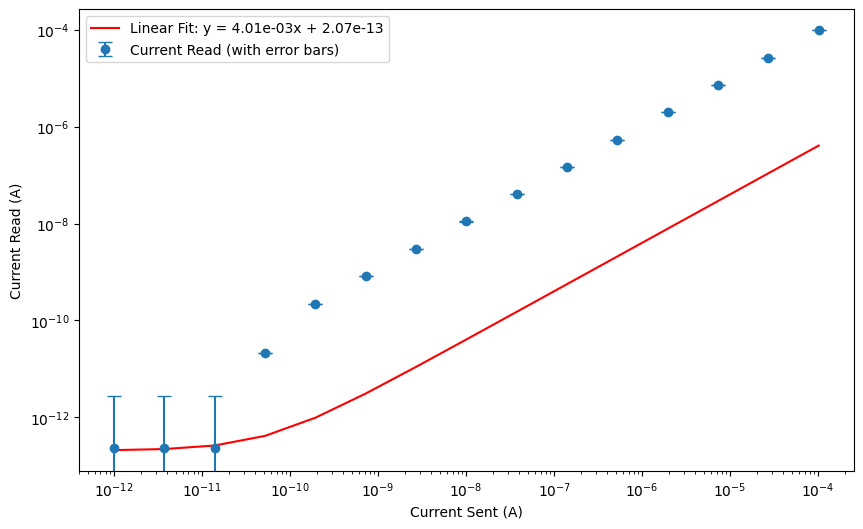

In [13]:
# Generate the fit line
fit_line = linear_model(correntes, slope, intercept)

# Plotting
plt.figure(figsize=(10,6), dpi=100)
plt.errorbar(correntes, means, yerr=y_errors, fmt='o', label='Current Read (with error bars)', capsize=5)
plt.plot(correntes, fit_line, 'r-', label=f'Linear Fit: y = {slope:.2e}x + {intercept:.2e}')
plt.xlabel('Current Sent (A)')
plt.ylabel('Current Read (A)')
plt.xscale('log')
plt.yscale('log')
plt.legend()

# Save and show the plot
#plt.savefig('current_vs_read_weighted_fit.pdf', bbox_inches='tight')
plt.show()

Slope (m): 0.9692379846304313
Intercept (b): -5.831537778170721e-12


C:\Users\eduar\AppData\Local\Temp\ipykernel_115744\1593717048.py:36: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1.5*10**-4)


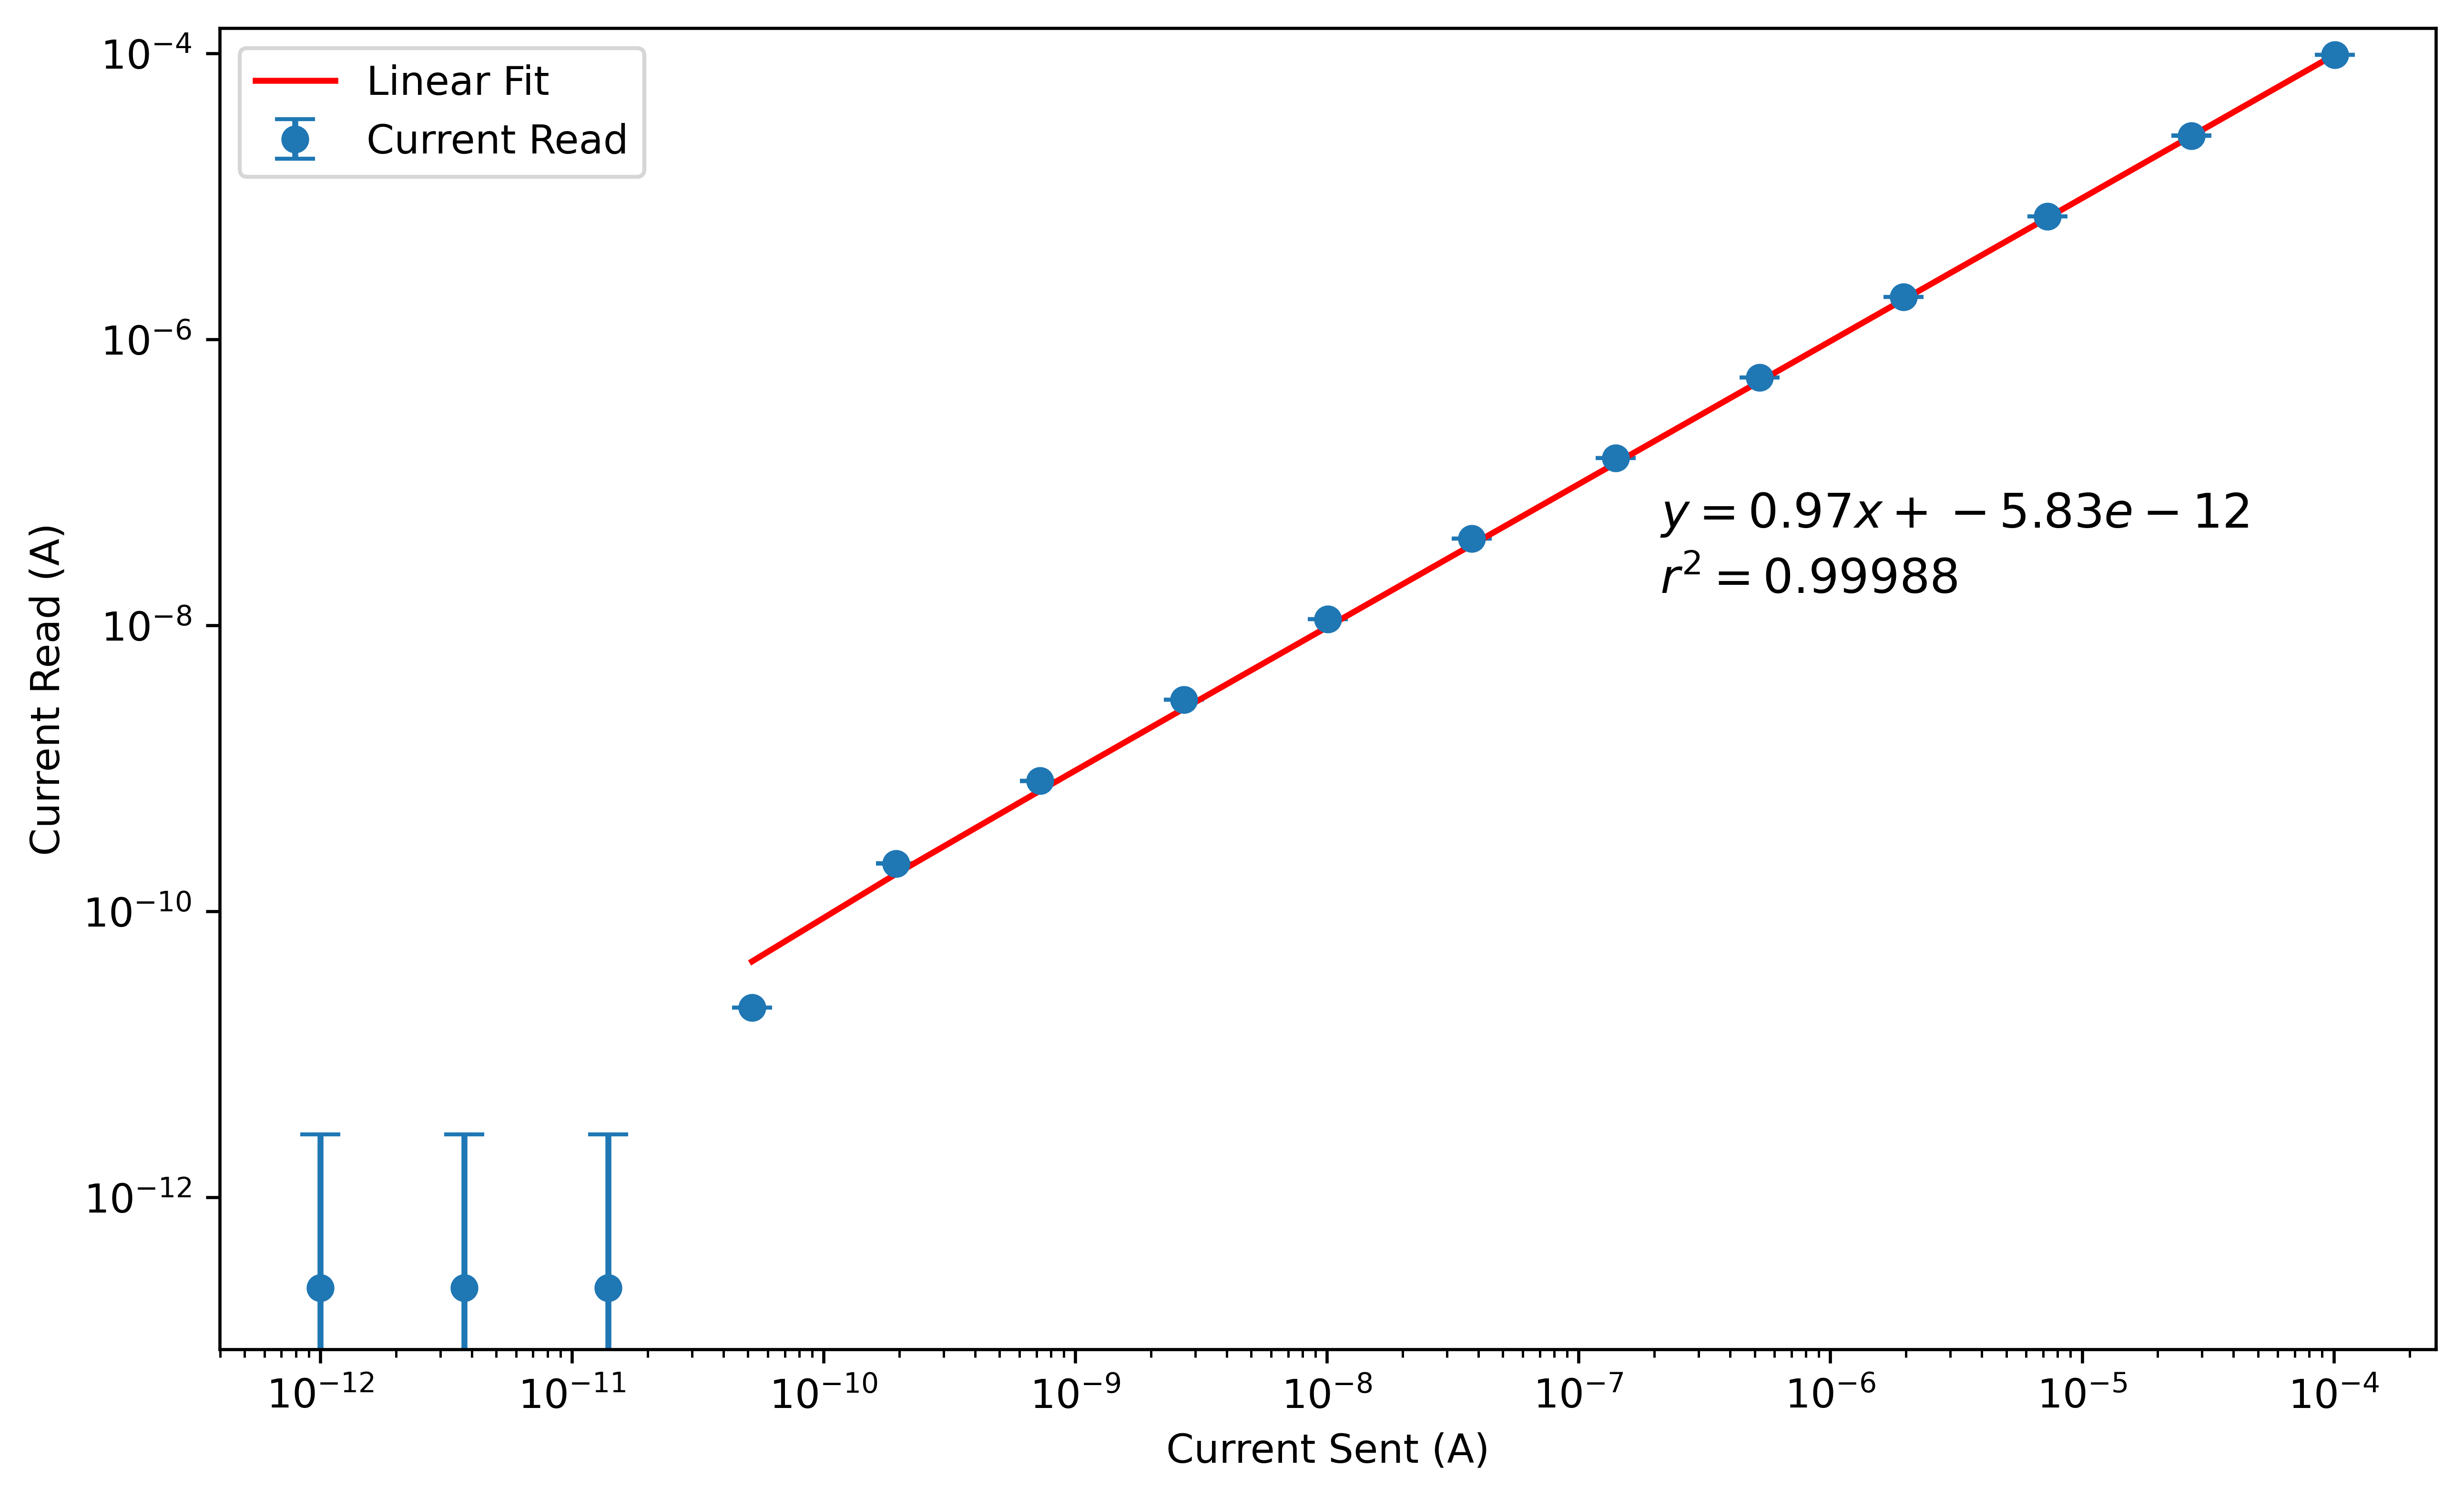

In [42]:
"""def weighted_linear_fit(x, y, weights):
    # Calculate weighted means of x and y
    sum_w = sum(weights)
    x_bar = sum([w * xi for w, xi in zip(weights, x)]) / sum_w
    y_bar = sum([w * yi for w, yi in zip(weights, y)]) / sum_w

    # Calculate the slope (m)
    num_m = sum([w * (xi - x_bar) * (yi - y_bar) for w, xi, yi in zip(weights, x, y)])
    denom_m = sum([w * (xi - x_bar)**2 for w, xi in zip(weights, x)])
    m = num_m / denom_m

    # Calculate the intercept (b)
    b = y_bar - m * x_bar

    return m, b"""

# Example data points with weights
x = correntes
y = means
weights = 1/std_devs  # Example weights

print(f"Slope (m): {m}")
print(f"Intercept (b): {b}")

# Plotting
plt.figure(figsize=(10,6), dpi=600)
plt.errorbar(x, y, yerr=y_errors, fmt='o', label='Current Read', capsize=5)
plt.plot(x[3:], m*x[3:]+b, 'r-', label='Linear Fit')
#correlation = mpatches.Patch(label=f'$r^2={round(r**2,5)}$')
plt.text(0.65, 0.65, f'$y = {m:.2f}x + {b:.2e}$', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')#, bbox=dict(facecolor='white', alpha=0.5))
plt.text(0.65, 0.6, f'$r^2 = {round(r**2,5)}$', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')#, bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Current Sent (A)')
plt.ylabel('Current Read (A)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0, 1.5*10**-4)
#plt.legend()
plt.legend()

# Save and show the plot
plt.savefig('current_vs_read_weighted_fit.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [21]:
def weighted_linear_fit_with_uncertainties(x, y, weights):
    # Calculate weighted means of x and y
    sum_w = sum(weights)
    x_bar = sum([w * xi for w, xi in zip(weights, x)]) / sum_w
    y_bar = sum([w * yi for w, yi in zip(weights, y)]) / sum_w

    # Calculate the slope (m)
    num_m = sum([w * (xi - x_bar) * (yi - y_bar) for w, xi, yi in zip(weights, x, y)])
    denom_m = sum([w * (xi - x_bar)**2 for w, xi in zip(weights, x)])
    m = num_m / denom_m

    # Calculate the intercept (b)
    b = y_bar - m * x_bar

    # Calculate the uncertainties (errors) in m and b
    sigma_m_square = sum_w / denom_m
    sigma_m = sigma_m_square**0.5

    sigma_b_square = sigma_m_square * (sum([w * xi**2 for w, xi in zip(weights, x)]) / sum_w)
    sigma_b = sigma_b_square**0.5

    # Calculate the weighted covariance
    cov_xy = sum([w * (xi - x_bar) * (yi - y_bar) for w, xi, yi in zip(weights, x, y)]) / sum_w

    # Calculate the weighted variances of x and y
    var_x = sum([w * (xi - x_bar)**2 for w, xi in zip(weights, x)]) / sum_w
    var_y = sum([w * (yi - y_bar)**2 for w, yi in zip(weights, y)]) / sum_w

    # Calculate the correlation coefficient (r)
    r = cov_xy / (var_x**0.5 * var_y**0.5)

    return m, b, sigma_m, sigma_b, r

x = correntes
y = means
weights = 1/std_devs  # Example weights

# Perform weighted linear fit with uncertainties
m, b, sigma_m, sigma_b, r = weighted_linear_fit_with_uncertainties(x, y, weights)

print(f"Slope (m): {m} ± {sigma_m}")
print(f"Intercept (b): {b} ± {sigma_b}")
print(round(r**2,5))


Slope (m): 0.9692379846304313 ± 320839411.1643921
Intercept (b): -5.831537778170721e-12 ± 1.000002487463359
0.99988
